# Filtering using taxmapper

In [1]:
import pandas as pd
import seaborn as sns
import glob
import os
import matplotlib.pyplot as plt, matplotlib
from matplotlib.patches import Patch
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')

In [2]:
def format_taxmapper_freq(f, sample_info):
    df = pd.read_table(f, header=0, sep="\t")
    df.columns = ["taxa"] + list(df.columns[1:])
    dfm = pd.melt(df, id_vars="taxa", var_name="Sample", value_name="fraction")
    dfm = pd.merge(dfm, sample_info, left_on="Sample", right_index=True)
    return dfm

In [3]:
si11 = pd.read_table("../../samples/sample_info_2011.tsv", header=0, sep="\t", index_col=0, usecols=[0,1,2,3])
si11_order = si11.sort_values("Condition").index
week_order = si11.sort_values("Sampling date (week#)")
# Add rerun for P191_10
_ = pd.DataFrame(si11.loc["P191_10"]).T
_.index = ["P191_10.2"]
si11 = pd.concat([si11,_])
si11.head()

Plot  Condition Sampling date (week#)
229_1    C1    control                   W19
229_10   F1  treatment                   W20
229_11   F2  treatment                   W20
229_12   F3  treatment                   W20
229_13   C1    control                   W21

In [4]:
lvl1m = format_taxmapper_freq("../../results/report/taxmapper/taxa_freq_norm_lvl1.tsv", si11)
lvl2m = format_taxmapper_freq("../../results/report/taxmapper/taxa_freq_norm_lvl2.tsv", si11)

In [5]:
print("Maximum percentage of fungal reads using taxmapper is {}%".format(round(lvl2m.loc[lvl2m.taxa=="Fungi","fraction"].max()*100)))

Maximum percentage of fungal reads using taxmapper is 15.0%


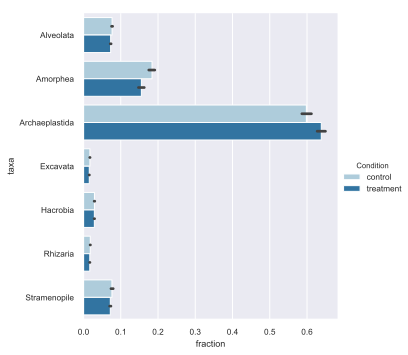

In [6]:
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=0.75, color_codes=True, rc=None)
ax = sns.catplot(data=lvl1m, kind="bar", x="fraction", y="taxa", hue="Condition", palette="Paired")
plt.savefig("../../results/figures/taxmapper_lvl1.png", dpi=300, bbox_inches="tight")

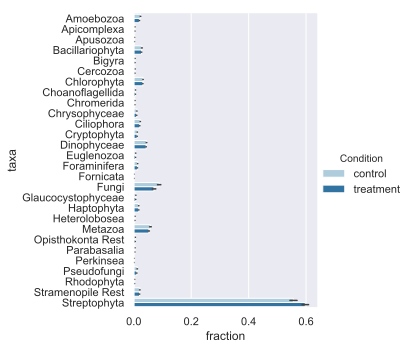

In [7]:
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)
ax = sns.catplot(data=lvl2m, kind="bar", x="fraction", y="taxa", hue="Condition", errwidth=1.5, palette="Paired")
plt.savefig("../../results/figures/taxmapper_lvl2.png", dpi=300, bbox_inches="tight")

### Compare reads identified via bowtie2 and taxmapper

In [8]:
taxmapper_fungi_reads = pd.read_table("../../results/report/taxmapper/taxmapper_fungi_reads.tsv", index_col=0, header=None, names=["Sample","Taxmapper"])
bt2_fungi_reads = pd.read_table("../../results/report/filtering/bowtie2_fungi_reads.tsv", index_col=0, header=None, names=["Sample","Bowtie2"])
fungi_reads = pd.merge(taxmapper_fungi_reads, bt2_fungi_reads, left_index=True, right_index=True)
fungi_reads = pd.merge(fungi_reads, si11, left_index=True, right_index=True)
fungi_reads = fungi_reads.assign(Ratio = pd.Series(fungi_reads.Bowtie2 / fungi_reads.Taxmapper, index=fungi_reads.index))
fungi_reads.to_csv("../../results/report/fungi_reads.tsv", sep="\t")
fungi_reads_m = pd.melt(fungi_reads.reset_index(), id_vars=["index","Plot","Condition","Sampling date (week#)"], var_name="Method",value_name="Reads")
fungi_reads_m.rename(columns={"index": "Sample"}, inplace=True)

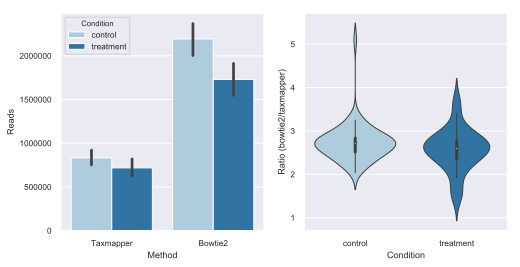

In [9]:
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=0.75, color_codes=True, rc=None)
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))
ax1 = sns.violinplot(data=fungi_reads_m.loc[fungi_reads_m.Method=="Ratio"], x="Condition", y="Reads", palette="Paired", linewidth=1, ax=axes[1])
ax1.set_ylabel("Ratio (bowtie2/taxmapper)");
ax2 = sns.barplot(data=fungi_reads_m.loc[fungi_reads_m.Method.isin(["Taxmapper","Bowtie2"])], hue="Condition", y="Reads",x="Method", ax=axes[0], palette="Paired")
plt.savefig("../../results/figures/fungi_reads.png", dpi=300, bbox_inches="tight")

*Figure legend: Here we see that the bowtie2 filtering strategy captures more fungal reads in all samples*

#### Reads common and unique

In [10]:
comm = pd.read_table("../../results/report/filtering/fungi_common_unique_reads.tsv", header=0, sep="\t", index_col=0)
comm = pd.merge(comm, fungi_reads, left_index=True, right_index=True)
comm = comm.assign(Bowtie2_up = pd.Series(comm.Bowtie2_u.div(comm.Bowtie2)*100, index=comm.index))
comm = comm.assign(Taxmapper_up = pd.Series(comm.Taxmapper_u.div(comm.Taxmapper)*100, index=comm.index))
comm = comm.assign(Bowtie2_commp = pd.Series(comm.Common.div(comm.Bowtie2)*100, index=comm.index))
comm = comm.assign(Taxmapper_commp = pd.Series(comm.Common.div(comm.Taxmapper)*100, index=comm.index))
comm_m = pd.melt(comm.reset_index(), id_vars=["index","Plot","Condition","Sampling date (week#)"])
comm_m.rename(columns={"index": "Sample"}, inplace=True)
print("{}% of Bowtie2 reads are unique, {}% of Taxmapper reads are unique".format(round(comm.Bowtie2_up.mean()), round(comm.Taxmapper_up.mean())))

62% of Bowtie2 reads are unique, 44% of Taxmapper reads are unique


In [11]:
comm2 = pd.read_table("../../results/report/filtering/fungi_spruce_common_unique_reads.tsv", header=0, sep="\t", index_col=0, names=["sample","bowtie2_spruce","taxmapper","common_spruce"])
comm2_counts = {"229_1": 794683, "229_10": 1255194, "229_11": 938072, "229_12": 1130746, "229_13": 1387377, "229_14": 1561789, "229_15": 1334389, "229_16": 1198004,
                "229_17": 1578252, "229_18": 1380156}
comm2 = pd.merge(comm2,comm,left_index=True, right_index=True)
comm2 = comm2.assign(Bowtie2_spruce_up = pd.Series(comm2.bowtie2_spruce.div(comm2.Bowtie2)*100, index=comm2.index))
comm2 = comm2.assign(Taxmapper_spruce_up = pd.Series(comm2.taxmapper.div(comm.Taxmapper)*100, index=comm2.index))
print("{}% of Bowtie2 reads are unique post spruce, {}% of Taxmapper reads are unique post spruce".format(round(comm2.Bowtie2_spruce_up.mean()), round(comm2.Taxmapper_spruce_up.mean())))
comm2 = pd.merge(comm2,pd.DataFrame(comm2_counts, index=["fungi_ps"]).T, left_index=True,right_index=True)

62% of Bowtie2 reads are unique post spruce, 46% of Taxmapper reads are unique post spruce
